# Submission 2

Kaggle team name: [55] Ship Happens

Course: TDT4173 Modern Machine Learning in Practice

Year: 2024

Group name: [55] Ship Happens

Group members:
| Name     | StudentId |
| -------- | ------- |
| Live Krohg  | 564347    |
| Ingvild Langeggen  | 564371     |
| Alexander Sundquist    | 132896    |


In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt
from pyproj import Transformer
from shapely.geometry import MultiPoint

## Retreiving data and data cleanup

In [19]:
train = pd.read_csv('ais_train.csv', sep='|')
train['time'] = pd.to_datetime(train['time'])
train.info()
missing_values = train.isnull().sum()
print("Number of missing values in each column:\n", missing_values)

train.head()

test = pd.read_csv('ais_test.csv', sep=',')
test['time'] = pd.to_datetime(test['time'])
test.head()

vessels = pd.read_csv('vessels.csv', sep='|')
vessels.head()

ports = pd.read_csv('ports.csv', sep='|')
ports.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522065 entries, 0 to 1522064
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       1522065 non-null  datetime64[ns]
 1   cog        1522065 non-null  float64       
 2   sog        1522065 non-null  float64       
 3   rot        1522065 non-null  int64         
 4   heading    1522065 non-null  int64         
 5   navstat    1522065 non-null  int64         
 6   etaRaw     1522065 non-null  object        
 7   latitude   1522065 non-null  float64       
 8   longitude  1522065 non-null  float64       
 9   vesselId   1522065 non-null  object        
 10  portId     1520450 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 127.7+ MB
Number of missing values in each column:
 time            0
cog             0
sog             0
rot             0
heading         0
navstat         0
etaRaw          0

,portId,name,portLocation,longitude,latitude,UN_LOCODE,countryName,ISO
0,61d36ed80a1807568ff9a064,Port of Algiers,Algiers,3.067222,36.773611,DZALG,Algeria,DZ
1,61d36ed80a1807568ff9a065,Port of Annaba,Annaba,7.772500,36.900556,DZAAE,Algeria,DZ
2,61d36edf0a1807568ff9a070,Port of Oran,Oran,-0.639722,35.712222,DZORN,Algeria,DZ
3,61d36ee00a1807568ff9a072,Port of Skikda,Skikda,6.905833,36.887500,DZSKI,Algeria,DZ
4,61d36ee10a1807568ff9a074,Port of Pago-Pago,Pago-Pago,-170.690556,-14.274167,ASPPG,American Samoa,AS


### Creating ID-mappings

In [20]:
port_id_mapping = {port_id: idx for idx, port_id in enumerate(train['portId'].unique())}
train['portId'] = train['portId'].map(port_id_mapping)
ports['portId'] = ports['portId'].map(port_id_mapping)


vessel_id_mapping = {vessel_id: idx for idx, vessel_id in enumerate(train['vesselId'].unique())}
train['vesselId'] = train['vesselId'].map(vessel_id_mapping)
vessels['vesselId'] = vessels['vesselId'].map(vessel_id_mapping)
test['vesselId'] = test['vesselId'].map(vessel_id_mapping)

# Create a DataFrame to visualize the vessel ID mapping
vessel_id_mapping_df = pd.DataFrame(list(vessel_id_mapping.items()), columns=['Original Vessel ID', 'Mapped Vessel ID'])


shipping_line_id_mapping = {shipping_line_id: idx for idx, shipping_line_id in enumerate(vessels['shippingLineId'].unique())}
vessels['shippingLineId'] = vessels['shippingLineId'].map(shipping_line_id_mapping)



## Feature engineering

### Creating Area covered and five-day-window features

In [ ]:
def compute_area_covered(dataframe, group_by_column='vesselId'):
    dataframe['area_covered'] = 0.0
    transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)  # WGS84 to Web Mercator

    for vessel_id, group in dataframe.groupby(group_by_column):
        coordinates = group[['longitude', 'latitude']].dropna().values
        if len(coordinates) >= 3:
            x_coords, y_coords = transformer.transform(coordinates[:, 0], coordinates[:, 1])
            projected_coordinates = list(zip(x_coords, y_coords))
            
            convex_hull = MultiPoint(projected_coordinates).convex_hull
            area_in_square_meters = convex_hull.area  
            area_in_square_kilometers = area_in_square_meters / 1e6  
        else:
            area_in_square_kilometers = 0
        
        # Assign the area back to each row in the group
        dataframe.loc[group.index, 'area_covered'] = area_in_square_kilometers

    return dataframe

In [ ]:
def create_five_day_windows(df):
    # Ensure that 'time' column is in datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    # Sort data to ensure time sequence within each vessel
    df = df.sort_values(by=['vesselId', 'time']).reset_index(drop=True)
    
    window_size_days = 5
    windows = []

    for vessel_id, group in df.groupby('vesselId'):
        group = group.sort_values(by='time')
        unique_dates = group['time'].dt.date.unique()

        for start_idx in range(len(unique_dates) - window_size_days + 1):
            start_date = unique_dates[start_idx]
            end_date = unique_dates[start_idx + window_size_days - 1]
            window = group[(group['time'].dt.date >= start_date) & (group['time'].dt.date <= end_date)]

            # Skip empty windows
            if len(window) == 0:
                continue

            # Reference row: the first row in the window
            reference_row = window.iloc[0]

            # Append each row in this window with reference features from the first row
            for _, row in window.iterrows():
                windows.append({
                    'vesselId': row['vesselId'],
                    'time': row['time'],
                    'latitude': row['latitude'],
                    'longitude': row['longitude'],
                    'cog': row['cog'],
                    'sog': row['sog'],
                    'under_way': row['under_way'],
                    # Features based on the first row in the window
                    'latitude_first': reference_row['latitude'],
                    'longitude_first': reference_row['longitude'],
                    'cog_first': reference_row['cog'],
                    'sog_first': reference_row['sog'],
                    'under_way_first': reference_row['under_way'],
                    'time_since_start': (row['time'] - reference_row['time']).total_seconds()
                })

    return pd.DataFrame(windows)

### Main feature-engineering function

In [ ]:
def feature_engineering(train):
    train = train.copy()

    # Sort data to ensure time sequence within each vessel
    train = train.sort_values(by=['vesselId', 'time']).reset_index(drop=True)

    # Handle NaNs by filling forward then backward within each vessel's data
    train[['latitude', 'longitude', 'cog', 'time']] = (
        train.groupby('vesselId')[['latitude', 'longitude', 'cog', 'time']].apply(lambda x: x.ffill().bfill())
    ).reset_index(drop=True)

    features = pd.DataFrame()
    features['vesselId'] = train['vesselId']
    features['time'] = train['time']
    features['latitude'] = train['latitude']
    features['longitude'] = train['longitude']
    features['cog'] = train['cog']
    features['sog'] = train['sog']
    features['under_way'] = train['navstat'].isin([0, 8]).astype(int)
    
    # Create five-day sliding windows for each vessel
    features = create_five_day_windows(features)
    features = compute_area_covered(features)

    # Additional time and angle transformations
    features['month'] = features['time'].dt.month
    features['day'] = features['time'].dt.day
    features['hour'] = features['time'].dt.hour
    features['minute'] = features['time'].dt.minute

    return features

train_features = feature_engineering(train)

### Checking the features are as they should

In [ ]:
nan_values = train_features.isnull().sum()
print(nan_values)

# Drop the column 'time'
train_features = train_features.drop(columns=['time'])

# Drop the rows with missing values
train_features = train_features.dropna().reset_index(drop=True)

nan_values = train_features.isnull().sum()
print(nan_values)

print(train_features.head())


vesselId            0
time                0
latitude            0
longitude           0
cog                 0
sog                 0
rot                 0
under_way           0
latitude_first      0
longitude_first     0
cog_first           0
sog_first           0
rot_first           0
under_way_first     0
time_since_start    0
area_covered        0
month               0
day                 0
hour                0
minute              0
dtype: int64
vesselId            0
latitude            0
longitude           0
cog                 0
sog                 0
under_way           0
latitude_first      0
longitude_first     0
cog_first           0
sog_first           0
under_way_first     0
time_since_start    0
area_covered        0
month               0
day                 0
hour                0
minute              0
dtype: int64
   vesselId  latitude  longitude    cog   sog  under_way  latitude_first  \
0         0 -34.74370  -57.85130  284.0   0.7          1        -34.7437   
1       

In [ ]:
def find_last_features(features):
    last_features = features.groupby('vesselId').last().reset_index()
    return last_features

last_features = find_last_features(train_features)
last_features.head()

,vesselId,latitude,longitude,cog,sog,under_way,latitude_first,longitude_first,cog_first,sog_first,under_way_first,time_since_start,area_covered,month,day,hour,minute
0,0,34.57936,128.99926,221.5,15.5,1,47.54253,-122.52499,53.8,0.4,0,1340708.0,1.781496e+08,5,1,12,41
1,1,1.24460,103.39997,305.1,15.7,1,24.98448,55.06391,81.6,0.1,0,2195733.0,9.016407e+07,4,30,10,12
2,2,18.13873,-69.74863,176.0,0.4,1,40.69757,-74.15090,0.0,0.0,0,603974.0,1.611915e+08,5,7,23,59
3,3,41.64055,143.29942,87.6,14.4,1,36.84741,125.83660,60.8,9.7,1,455585.0,1.580457e+07,4,26,13,29
4,4,26.58710,121.27831,39.1,12.7,1,1.26628,103.85164,341.0,0.0,0,562766.0,1.485581e+08,5,7,12,28


## Training the model

In [26]:
# Define features and target of heading model
y = train_features[['latitude', 'longitude']]  
X = train_features.drop(columns=['latitude', 'longitude']) 

In [27]:
# Initialize the xgboost model
model_heading = xgb.XGBRegressor()

# Fit the model
model_heading.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Preparing the test data for predictions

In [28]:
print(X.keys())
'''
['vesselId', 'cog', 'sog', 'under_way', 'latitude_first',
       'longitude_first', 'cog_first', 'sog_first', 'under_way_first',
       'time_since_start', 'area_covered', 'month', 'day', 'hour', 'minute']
'''

### Prepare test data for predictions
def prepare_test_for_predictions(test, last_features):
    test = test.copy()
    prepared_test = pd.DataFrame()

    # Create a time column in last features
    last_features['year'] = 2024
    last_features['time'] = pd.to_datetime(
        last_features[['year', 'month', 'day', 'hour', 'minute']]
    )

    # Add the columns vesselId and time
    prepared_test['vesselId'] = test['vesselId']
    prepared_test['time'] = test['time']

    # For each vessel, add the last seen features to the prepared test
    prepared_test = prepared_test.merge(last_features, on='vesselId', how='left', suffixes=('', '_last'))

    print(prepared_test.head())

    # Move the last_features to the refrence row in the windows
    prepared_test['latitude_first'] = prepared_test['latitude']
    prepared_test['longitude_first'] = prepared_test['longitude']
    prepared_test['cog_first'] = prepared_test['cog']
    prepared_test['sog_first'] = prepared_test['sog']
    prepared_test['under_way_first'] = prepared_test['under_way']
    prepared_test['time_since_start'] = (prepared_test['time'] - prepared_test['time_last']).dt.total_seconds()

    # Split the time column into month, day, hour, minute and second columns
    prepared_test['month'] = test['time'].dt.month
    prepared_test['day'] = test['time'].dt.day
    prepared_test['hour'] = test['time'].dt.hour
    prepared_test['minute'] = test['time'].dt.minute
    # prepared_test['second'] = test['time'].dt.second

    prepared_test.drop('time', axis=1, inplace=True)
    prepared_test.drop('time_last', axis=1, inplace=True)
    prepared_test.drop('year', axis=1, inplace=True)

    # Reorder the columns
    prepared_test = prepared_test[['vesselId', 'cog', 'sog', 'under_way',
                                   'latitude_first', 'longitude_first', 'cog_first', 'sog_first',
                                     'under_way_first', 'time_since_start', 'area_covered', 'month', 'day',
                                   'hour', 'minute']]

    return prepared_test

test_df = prepare_test_for_predictions(test, last_features)
print(test_df.head())
print(test_df.shape)


Index(['vesselId', 'cog', 'sog', 'under_way', 'latitude_first',
       'longitude_first', 'cog_first', 'sog_first', 'under_way_first',
       'time_since_start', 'area_covered', 'month', 'day', 'hour', 'minute'],
      dtype='object')
   vesselId                time  latitude  longitude    cog   sog  under_way  \
0       412 2024-05-08 00:03:16  31.14647  -81.49789  179.6   0.0          0   
1       373 2024-05-08 00:06:17  14.81694  120.29625   24.7   0.0          0   
2       181 2024-05-08 00:10:02  38.27895   10.78280    8.0  18.7          1   
3         8 2024-05-08 00:10:34 -43.53785  172.83522  321.3   0.1          0   
4        65 2024-05-08 00:12:27  48.53320   -6.12003  291.0   0.3          0   

   latitude_first  longitude_first  cog_first  sog_first  under_way_first  \
0        30.93466        -81.08673      159.0        0.0                0   
1        35.44624        139.71653       82.7        0.0                0   
2        38.00859         11.68428       40.0       1

## Predicting 

In [29]:
# Make predictions
predictions = model_heading.predict(test_df)
print(predictions)
print(predictions.shape)

[[  31.199514   -81.186424 ]
 [  19.72441    118.25942  ]
 [  38.71519     11.64568  ]
 ...
 [  30.725746  -126.4757   ]
 [  54.27217      5.313753 ]
 [  48.112816     2.7966747]]
(51739, 2)


In [30]:
# Create a DataFrame with the required format
predictions_df = pd.DataFrame(predictions, columns=['latitude_predicted', 'longitude_predicted'])
predictions_df['ID'] = range(len(predictions_df))
predictions_df = predictions_df[['ID', 'longitude_predicted', 'latitude_predicted']]

# Save to CSV
predictions_df.to_csv('predictions_2_new.csv', index=False)

## Model interpretation 

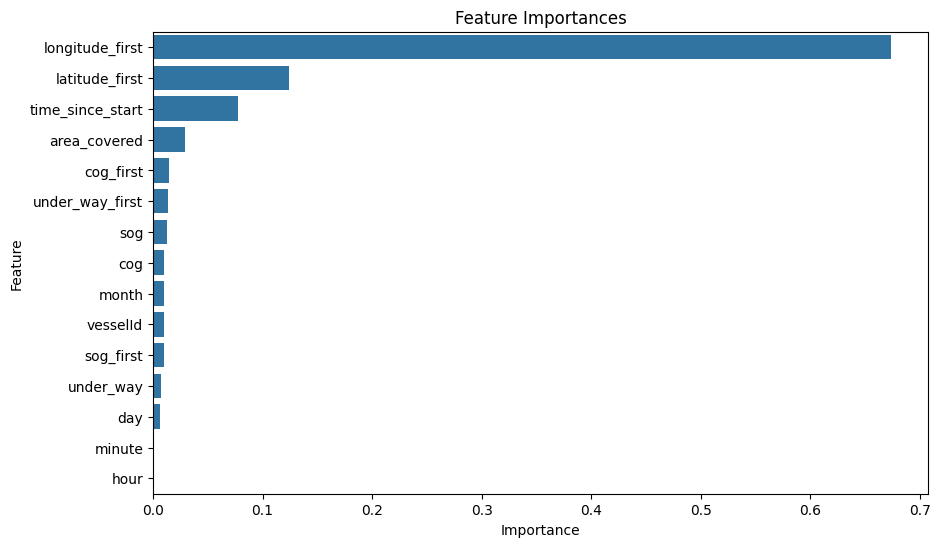

In [31]:
# Get feature importances
importances = model_heading.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()